<a href="https://colab.research.google.com/github/Neel7317/Computer_vision/blob/main/FatserRCNN_withPeacock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.5.0+cu101

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 623 kB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 42 kB 563 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=aded7a2fc0efb8d5931d9f7588d1654d6865576e98f0192c5ea2c90b4e7b0aa1
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31548 sha256=802e120c04d1e58e884edab2d2079bd7659ed54b5c6d7e74aad4a61ab4f38721
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CIN09Rro2OVyvtKslDTh")
project = rf.workspace("neelkanth-bhavnagarwala-f3irh").project("peacock_pro")
dataset = project.version(2).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 460 kB/s 
     |████████████████████████████████| 145 kB 8.9 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 138 kB 60.9 MB/s 
     |████████████████████████████████| 596 kB 61.4 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 178 kB 63.8 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b3407f0a903d01f981a87631d64515e4c0db5d832ed2b2441a9a68482df44ec9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to peacock_pro-2 in coco:: 100%|██████████| 140/140 [00:00<00:00, 1021.50it/s]


In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/peacock_pro-2/train/_annotations.coco.json", "/content/peacock_pro-2/train")
register_coco_instances("my_dataset_val", {}, "/content/peacock_pro-2/valid/_annotations.coco.json", "/content/peacock_pro-2/valid")
register_coco_instances("my_dataset_test", {}, "/content/peacock_pro-2/test/_annotations.coco.json", "/content/peacock_pro-2/test")

WARNING [11/17 11:03:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/17 11:03:09 d2.data.datasets.coco]: Loaded 117 images in COCO format from /content/peacock_pro-2/train/_annotations.coco.json


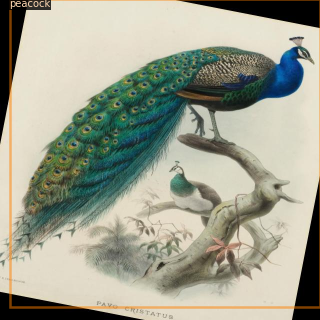

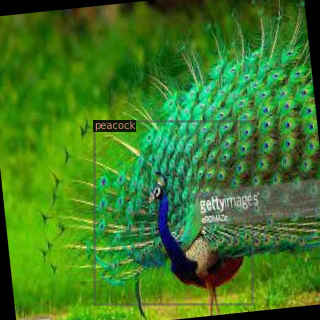

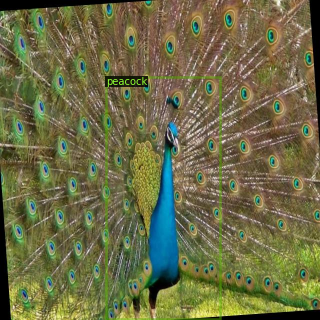

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 168 kB 62.1 MB/s 
     |████████████████████████████████| 182 kB 52.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 140 kB 68.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1dfb475d2fb1a13187e0febd33a05790a8d5b9ad8456b79f428b8396310c81d8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [1]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [6]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 150 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (100, 150)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 50


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/17 11:11:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:09, 45.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/17 11:11:52 d2.engine.train_loop]: Starting training from iteration 0
[11/17 11:12:29 d2.utils.events]:  eta: 0:04:10  iter: 19  total_loss: 1.412  loss_cls: 0.470  loss_box_reg: 0.883  loss_rpn_cls: 0.006  loss_rpn_loc: 0.011  time: 1.8946  data_time: 0.0357  lr: 0.001000  max_mem: 7647M
[11/17 11:13:10 d2.utils.events]:  eta: 0:03:38  iter: 39  total_loss: 0.805  loss_cls: 0.112  loss_box_reg: 0.670  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 1.9581  data_time: 0.0140  lr: 0.001000  max_mem: 7648M
WARNING [11/17 11:13:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/17 11:13:31 d2.data.datasets.coco]: Loaded 7 images in COCO format from /content/peacock_pro-2/valid/_annotations.coco.json
[11/17 11:13:31 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  peacock   | 0      

In [7]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/17 11:18:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/17 11:18:00 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/peacock_pro-2/test/_annotations.coco.json
[11/17 11:18:00 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  peacock   | 0            |  peacock   | 9            |
|            |              |            |              |
|   total    | 9            |            |              |
[11/17 11:18:00 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[11/17 11:18:00 d2.data.common]: Serialized dataset takes 0.00 MiB
[11/17 11:18:00 d2.evaluation.evaluator]: Start inference on 8 images
[11/17 11:18:03 d2.evaluation.evaluator]: Total inference time: 0:00:00.753429 (0.251143 s / img per device, on 1 devices)


OrderedDict([('bbox',
              {'AP': 38.08536498811172,
               'AP50': 84.4884488448845,
               'AP75': 32.45324532453246,
               'APs': nan,
               'APm': nan,
               'APl': 38.08536498811172,
               'AP-peacock': 38.08536498811172})])

In [8]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1668683502.87f864bc7195.449.0  metrics.json
instances_predictions.pth                          model_final.pth


In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

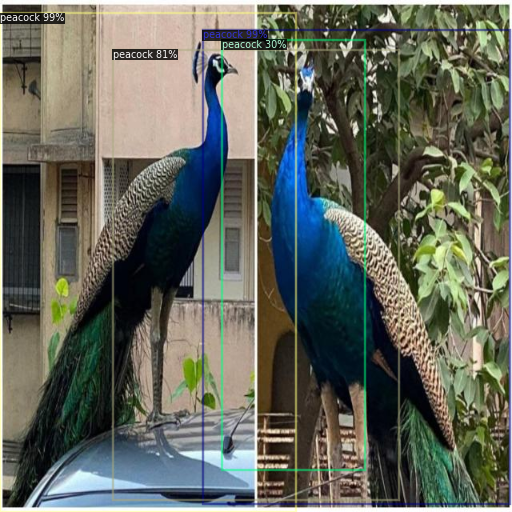

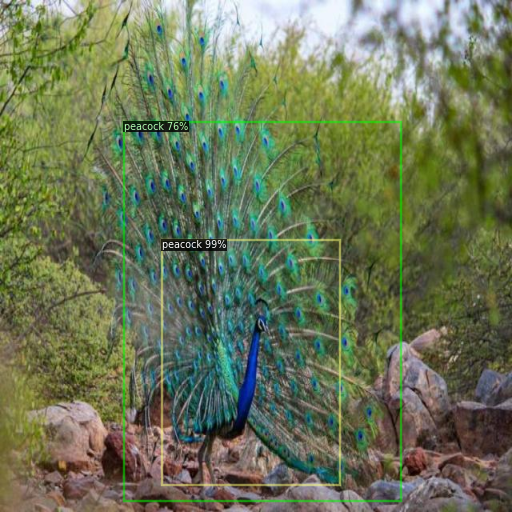

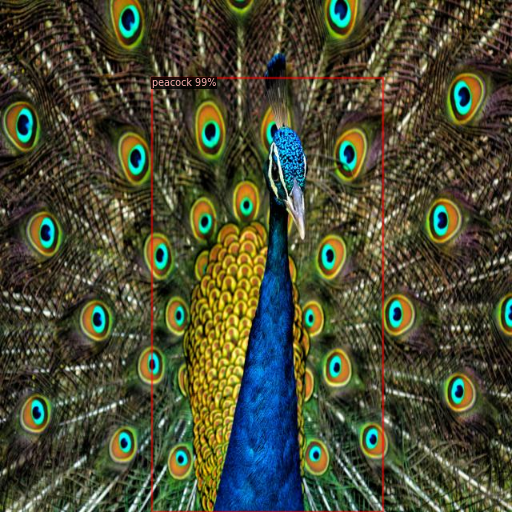

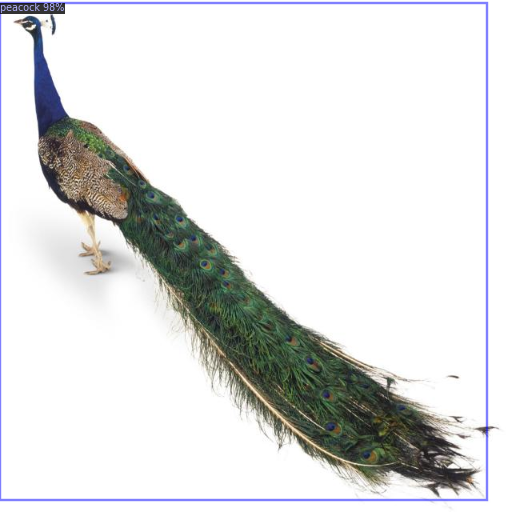

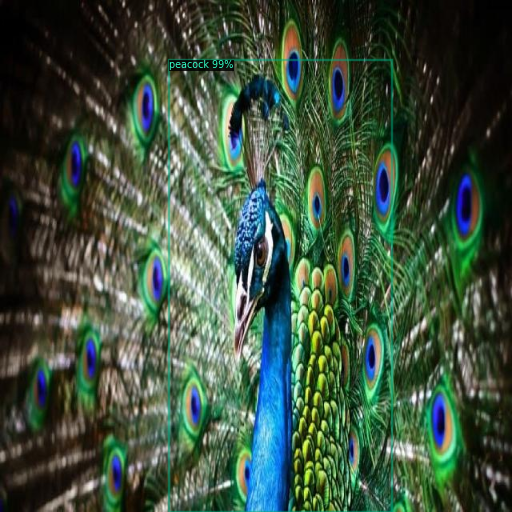

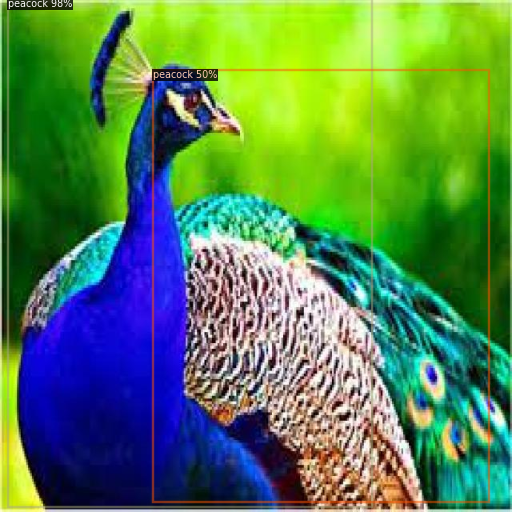

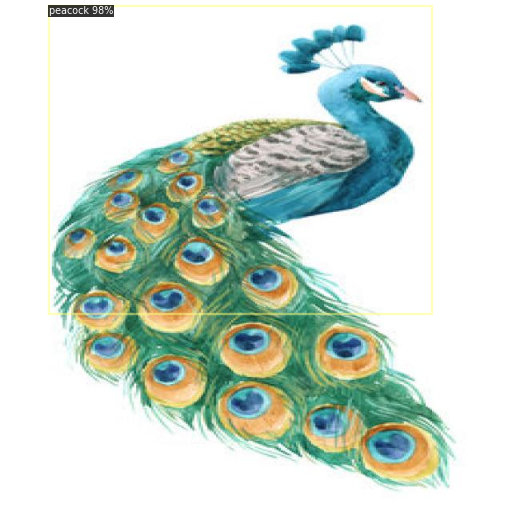

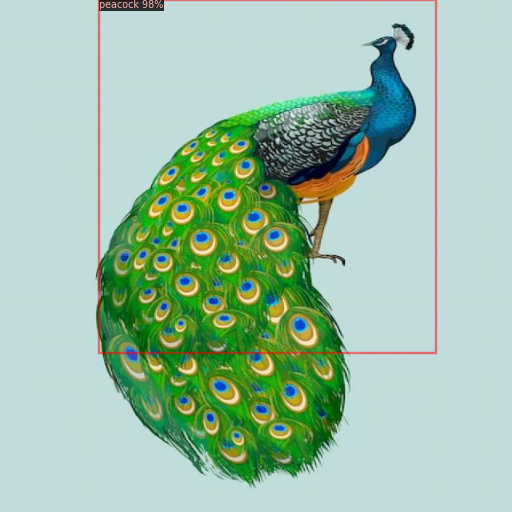

In [11]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/peacock_pro-2/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])